In [242]:
import scanpy as sc
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

In [2]:
healthy = sc.read_h5ad("GSE174188/GSE174188_Healthy.h5ad")
healthy

AnnData object with n_obs × n_vars = 486418 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'cell_type'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
sample = list(set(healthy.obs.ind_cov))

rows_to_remove = []
for i in sample:
    healthy = healthy[healthy.obs.Status == "Healthy", :]
    if healthy[healthy.obs.ind_cov == i,:].n_obs < healthy.n_obs*0.005:
        rows_to_remove.append(i)
    healthy_filter = healthy[~healthy.obs.ind_cov.isin(rows_to_remove),:]    

sample = list(set(healthy_filter.obs.ind_cov))

personal = {}
for i in sample:
    if i not in personal:
        personal[i] = healthy[healthy.obs.ind_cov == i, :]
        
# 將personal進行排序
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))
# 排序之後取得年齡
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])

In [52]:
DC = healthy_filter[healthy_filter.obs.cell_type == 'DC',:]
Monocyte = healthy_filter[healthy_filter.obs.cell_type == 'Monocyte',:]
NK = healthy_filter[healthy_filter.obs.cell_type == 'NK',:]
CD8T = healthy_filter[healthy_filter.obs.cell_type == 'CD8 T',:]
CD4T = healthy_filter[healthy_filter.obs.cell_type == 'CD4 T',:]
B = healthy_filter[healthy_filter.obs.cell_type == 'B',:]

In [161]:
# 將原始 umap & kmeans的umap畫出來做比較
def umap_compare(cell_type, label):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))  # 創建一個1行2列的子圖

    # 用 KMeans 在資料中找出 2 個分組
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(cell_type.X)
    cell_type.obs["kmeans"] = kmeans.labels_
    sc.pl.umap(cell_type, color="kmeans", ax = axs[0], show=False)  # 不立即顯示圖形

    kmeans.fit(cell_type.obsm['X_pca'])
    cell_type.obs["kmeans"] = kmeans.labels_
    sc.pl.umap(cell_type, color="kmeans", ax = axs[1], show=False)
    
    plt.savefig(f'Result_picture/GSE174188/K-means proportion trend/umap_compare_{label}.png', dpi=900)
    plt.show()  # 顯示所有圖形

# 進行k_means後proportion的計算
def kmeans_proportion_trend(ID, cell_type_anndata):
    kmeans_1 = []
    kmeans_2 = []
    for i in ID:
        # Get individual cell types from person
        person = cell_type_anndata[cell_type_anndata.obs.ind_cov == i,: ]
        # Get cell types proportion through k-means
        kmeans_1.append(len(person[person.obs.kmeans == 0,:])/len(person.obs.kmeans))
        kmeans_2.append(len(person[person.obs.kmeans == 1,:])/len(person.obs.kmeans))
    return kmeans_1, kmeans_2

# 有按照年齡進行排序之後的kmeans比例
# 畫kmeans之後的cell proportion的趨勢
def trend_line(cell_type, label):
    plt.figure()
    plt.plot(cell_type, label=label)
    # 添加圖例
    plt.legend()

    # 計算趨勢線
    z = np.polyfit(range(len(cell_type)), cell_type, 1)
    p = np.poly1d(z)
    # 繪製趨勢線
    plt.plot(p(range(len(cell_type))),'r--', label='Trend Line')
    
    
    plt.savefig(f'Result_picture/GSE174188/K-means proportion trend/trend_{label}.png', dpi=900)    
    plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


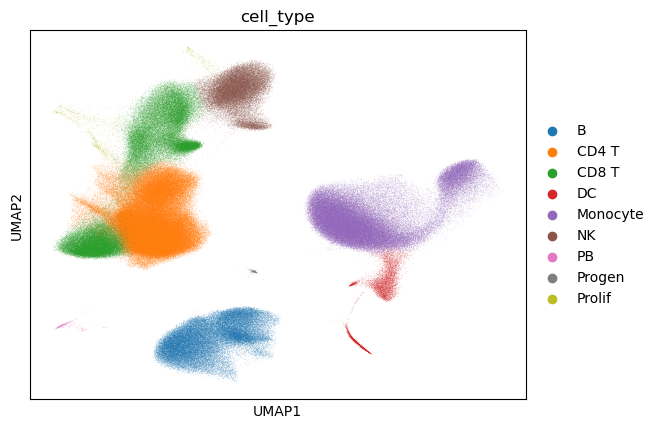

In [108]:
sc.pl.umap(healthy, color="cell_type")

# CD4 T

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


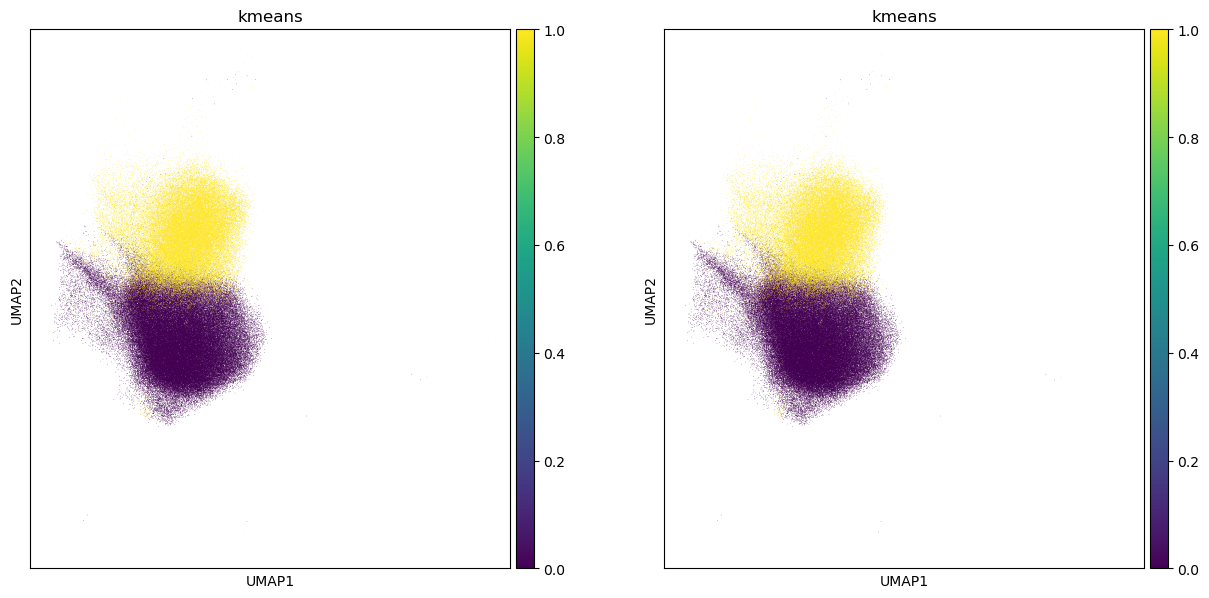

In [109]:
umap_compare(CD4T, "CD4 T")

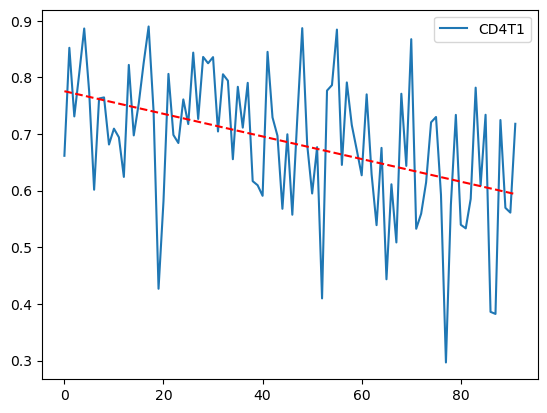

In [110]:
CD4T1, CD4T2 = kmeans_proportion_trend(sorted_personal, CD4T)
trend_line(CD4T1, "CD4T1")

# CD8 T

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\benson\AppData\Local\Temp\ipykernel_258108\4187086480.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cell_type.obs["kmeans"] = kmeans.labels_
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


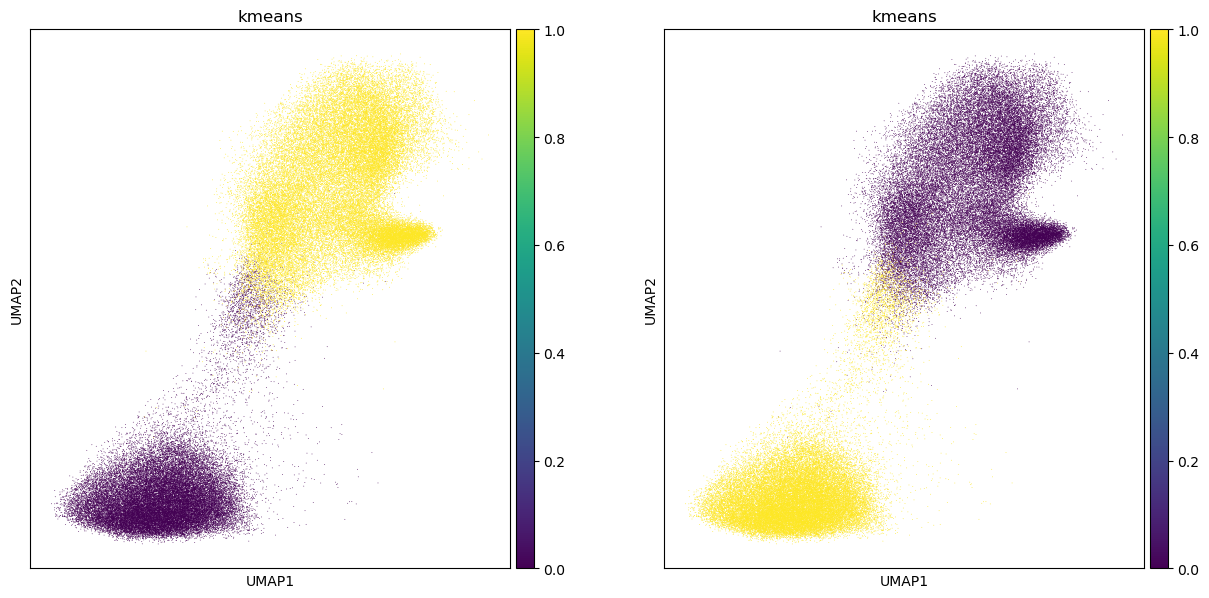

In [111]:
umap_compare(CD8T, "CD8 T")

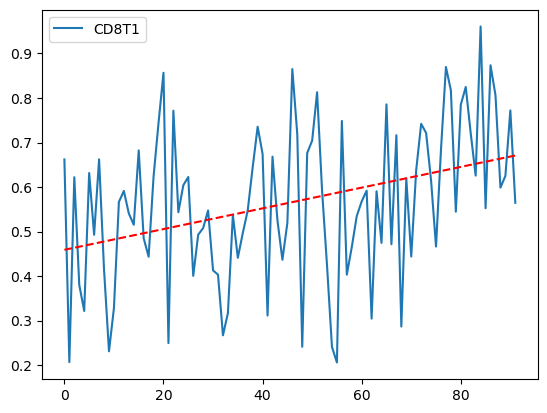

In [112]:
CD8T1, CD8T2 = kmeans_proportion_trend(sorted_personal, CD8T)
trend_line(CD8T1, "CD8T1")

# NK

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\benson\AppData\Local\Temp\ipykernel_258108\4187086480.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cell_type.obs["kmeans"] = kmeans.labels_
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


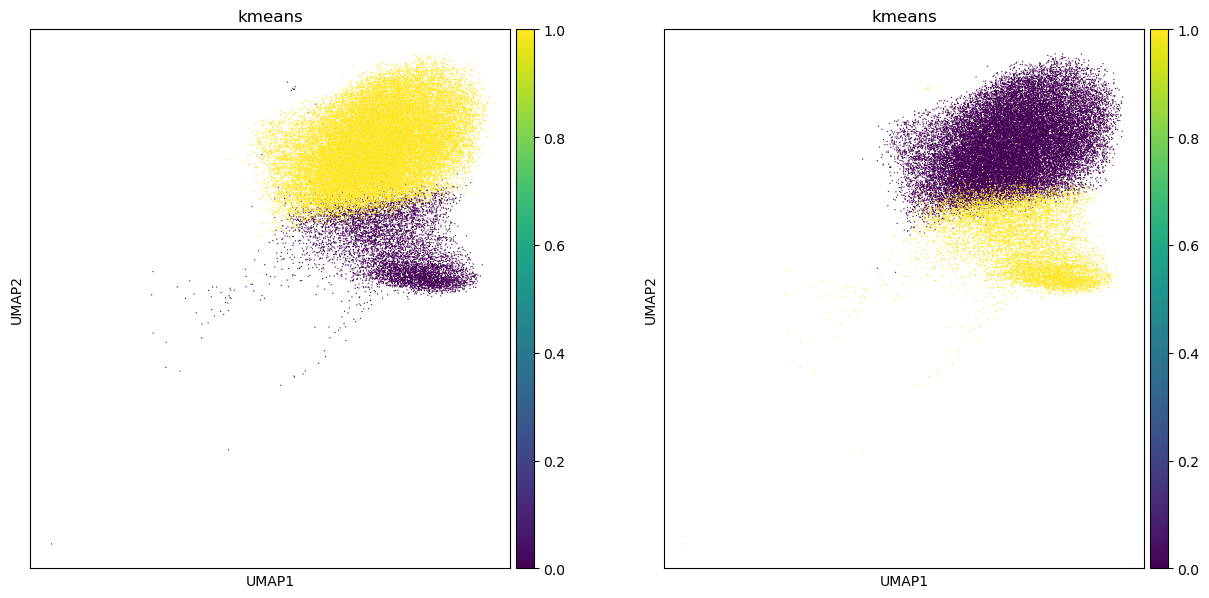

In [113]:
umap_compare(NK, "NK")

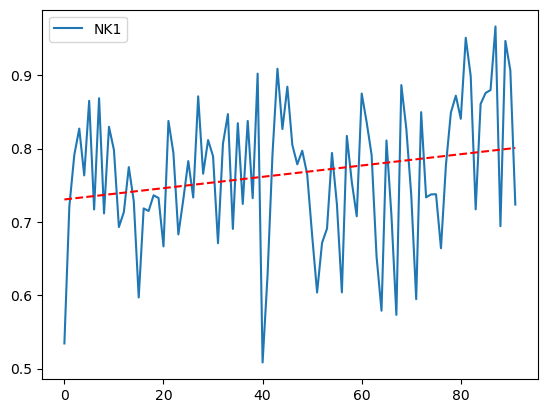

In [114]:
NK1, NK2 = kmeans_proportion_trend(sorted_personal, NK)
trend_line(NK1, "NK1")

# Monocyte

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\benson\AppData\Local\Temp\ipykernel_258108\4187086480.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cell_type.obs["kmeans"] = kmeans.labels_
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


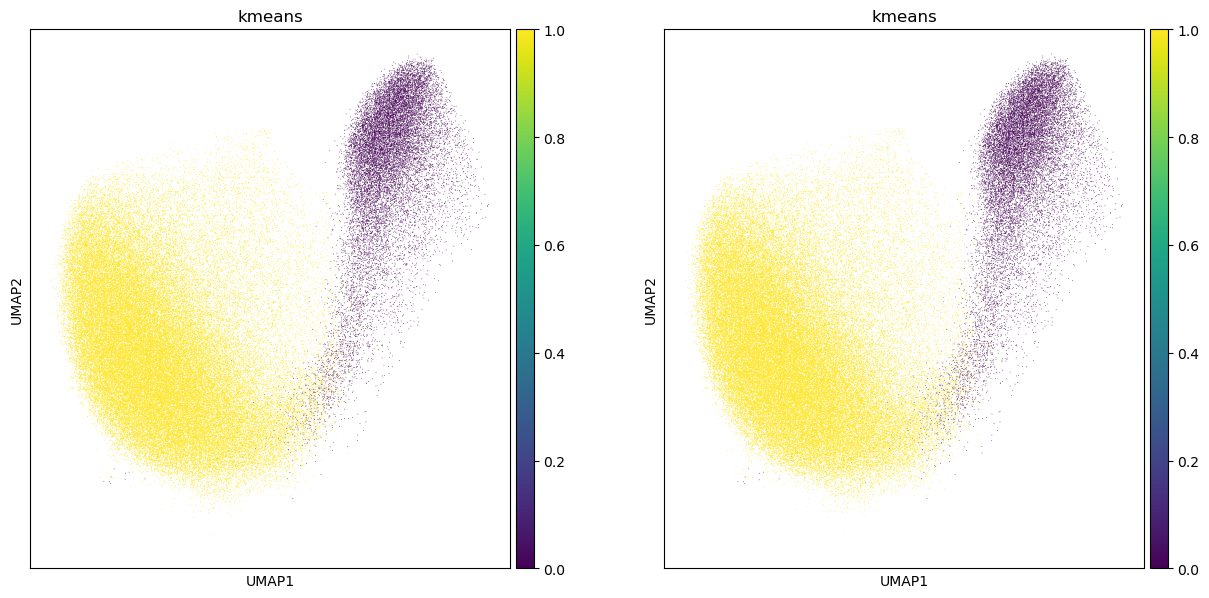

In [115]:
umap_compare(Monocyte,"Monocyte")

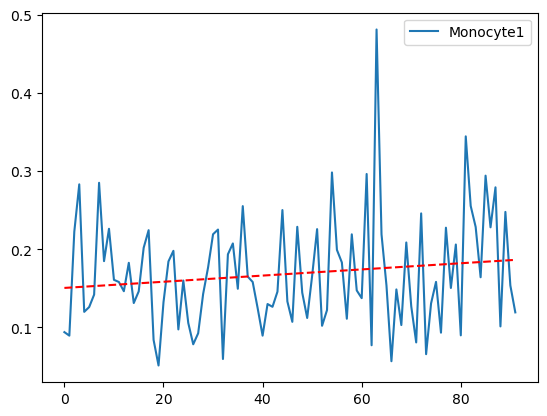

In [116]:
Monocyte1, Monocyte2 = kmeans_proportion_trend(sorted_personal, Monocyte)
trend_line(Monocyte1, "Monocyte1")

# DC

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\benson\AppData\Local\Temp\ipykernel_258108\4187086480.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cell_type.obs["kmeans"] = kmeans.labels_
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


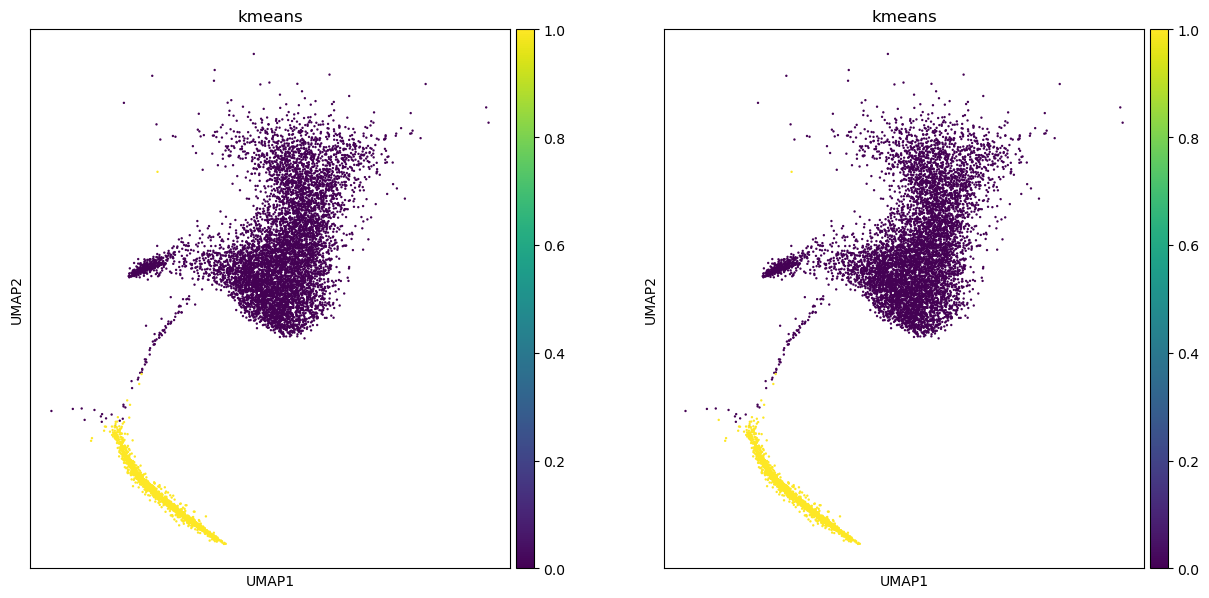

In [117]:
umap_compare(DC, "DC")

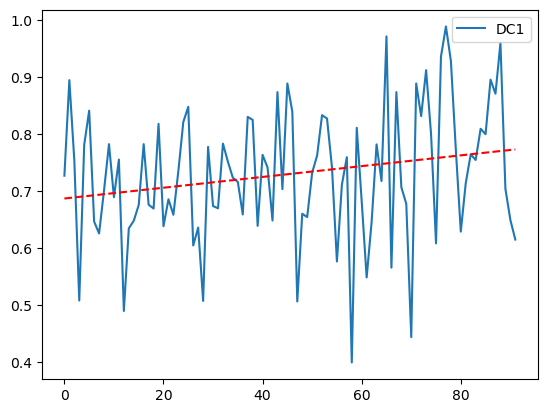

In [118]:
DC1, DC2 = kmeans_proportion_trend(sorted_personal, DC)
trend_line(DC1, "DC1")

# B

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


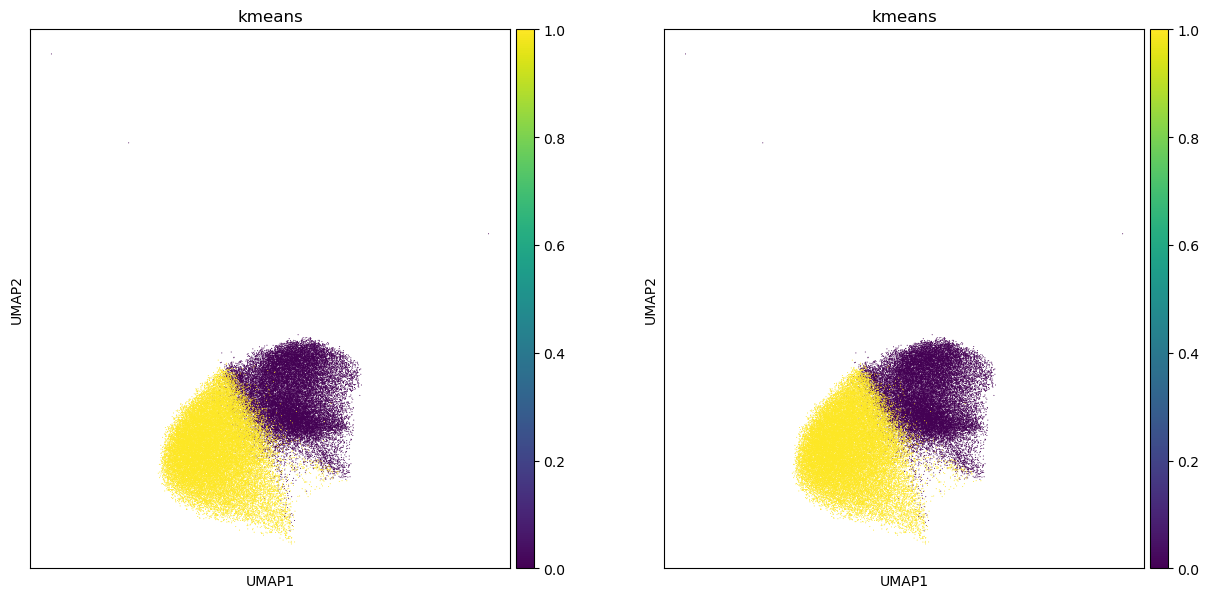

In [119]:
umap_compare(B, "B")

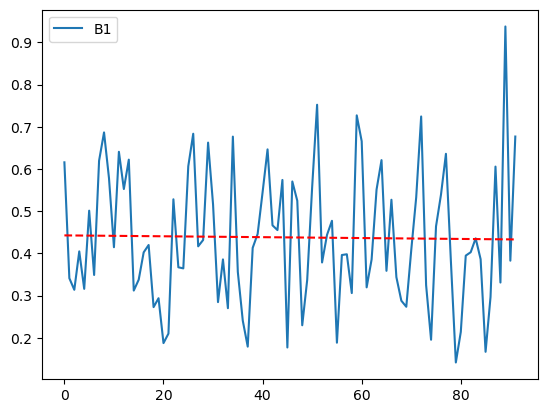

In [120]:
B1, B2 = kmeans_proportion_trend(sorted_personal, B)
trend_line(B1, "B1")

# Pearson Correlation

In [184]:
age_float = [float(i) for i in age]
CD4T_corr, CD4T_pvalue = pearsonr(CD4T1, age_float)
CD8T_corr, CD8T_pvalue = pearsonr(CD8T1, age_float)
NK_corr, NK_pvalue = pearsonr(NK1, age_float)
Monocyte_corr, Monocyte_pvalue = pearsonr(Monocyte1, age_float)
DC_corr, DC_pvalue = pearsonr(DC1, age_float)
B_corr, B_pvalue = pearsonr(B1, age_float)

In [190]:
print(f'CD4T_corr:{CD4T_corr}\nCD8T_corr:{CD8T_corr}\nNK_corr:{NK_corr}\nMonocyte_corr:{Monocyte_corr}\nDC_corr:{DC_corr}\nB_corr:{B_corr}\n') 

CD4T_corr:-0.405368754071226
CD8T_corr:0.4185589543619524
NK_corr:0.3155489169808363
Monocyte_corr:0.16761721173211058
DC_corr:0.23536541826229682
B_corr:0.016049374934020026



In [192]:
print(f'CD4T_pvalue:{CD4T_pvalue}\nCD8T_pvalue:{CD8T_pvalue}\nNK_pvalue:{NK_pvalue}\nMonocyte_pvalue:{Monocyte_pvalue}\nDC_pvalue:{DC_pvalue}\nB_pvalue:{B_pvalue}\n') 

CD4T_pvalue:6.110460773276926e-05
CD8T_pvalue:3.294465962957509e-05
NK_pvalue:0.002184423711670677
Monocyte_pvalue:0.11025075694560761
DC_pvalue:0.023914020342130207
B_pvalue:0.8793090429792647



# 將K-means寫入csv中

In [266]:
# Get IDs that sort by age
key = list(sorted_personal.keys())

df = pd.DataFrame()
df.index = key

df["CD4T_kmeans_1"] = CD4T1
df["CD4T_kmeans_2"] = CD4T2
df["CD8T_kmeans_1"] = CD8T1
df["CD8T_kmeans_2"] = CD8T2
df["NK_kmeans_1"] = NK1
df["NK_kmeans_2"] = NK2
df["Monocyte_kmeans_1"] = Monocyte1
df["Monocyte_kmeans_2"] = Monocyte2
df["DC_kmeans_1"] = DC1
df["DC_kmeans_2"] = DC2
df["B_kmeans_1"] = B1
df["B_kmeans_2"] = B2

df

,CD4T_kmeans_1,CD4T_kmeans_2,CD8T_kmeans_1,CD8T_kmeans_2,NK_kmeans_1,NK_kmeans_2,Monocyte_kmeans_1,Monocyte_kmeans_2,DC_kmeans_1,DC_kmeans_2,B_kmeans_1,B_kmeans_2
HC-519,0.661579,0.338421,0.661955,0.338045,0.534351,0.465649,0.093849,0.906151,0.727273,0.272727,0.615789,0.384211
HC-520,0.852217,0.147783,0.206849,0.793151,0.721154,0.278846,0.089362,0.910638,0.894737,0.105263,0.341121,0.658879
IGTB1974_IGTB1974,0.731076,0.268924,0.622087,0.377913,0.791469,0.208531,0.222362,0.777638,0.754717,0.245283,0.313636,0.686364
IGTB1987_IGTB1987,0.807356,0.192644,0.380165,0.619835,0.827381,0.172619,0.282885,0.717115,0.508475,0.491525,0.404706,0.595294
IGTB1901_IGTB1901,0.886270,0.113730,0.321656,0.678344,0.763547,0.236453,0.119792,0.880208,0.781609,0.218391,0.315888,0.684112
...,...,...,...,...,...,...,...,...,...,...,...,...
HC-540,0.382452,0.617548,0.806202,0.193798,0.966667,0.033333,0.279070,0.720930,0.870968,0.129032,0.605670,0.394330
HC-536,0.724701,0.275299,0.598698,0.401302,0.694323,0.305677,0.101179,0.898821,0.960000,0.040000,0.330846,0.669154
HC-524,0.569716,0.430284,0.625000,0.375000,0.946984,0.053016,0.247629,0.752371,0.704545,0.295455,0.937812,0.062188
HC-022,0.561267,0.438733,0.771996,0.228004,0.906667,0.093333,0.153578,0.846422,0.650000,0.350000,0.382671,0.617329


In [268]:
df.to_csv('GSE174188_Healthy_kmeans_20240122.csv', index=True)